The problem with a few of the sampling implementations for spatial parameters in SAR/ER setups I've seen so far is that they either: 

1. Incorrectly truncate the posterior distribution, resulting in biased parameter estimates. 
2. They don't implement Hastings Factors for truncated proposal distributions

1 is a little harder to fix, but can be done by using MH sampling. 2 is simple, and just involves correctly calibrating the forward-backward transition probabilities.

In [1]:
from hlm.abstracts import Metropolis_Mixin, Abstract_Step, Gibbs
import numpy as np
np.random.seed(1000)
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/home/ljw/.local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


The way I think it makes sense to implement new sampling methods is to make them mixin classes that add the necessary functionality, like the `Reg_Props_*` classes in pysal.

So, we can make a class that will attempt to sample by default from a gamma distribution, which has a restricted range. If this is done without using the Hastings factor, the samples will be biased. Via the detailed balance constraints, the Metropolis-Hastings decision rule is to accept some proposal parameter value with probability:

$$ min \left\{1, \frac{P(x')}{P(x)} \frac{g(x|x')}{g(x'|x)} \right\} $$

where $g$ is the jump/proposal function, and $P$ is proportional to the sampling likelihood.

Typically, if the sampling occurs on an unrestricted domain using a symmetric proposal, $g(x'|x) = g(x|x')$, so we only need to compare the ratio of probabilities. 

However, for spatial parameters, we usually implicitly restrict their sampling range. Thus, we need to actually compute the normalization factor for the restricted parameter.

So, there are three functions that get added to a sampling step if it's defined using `Metropolis_Mixin:
- `_metropolis` : the metropolis choice shown above for random walk sampling
- `_propose` : propose a new parameter new value, and compute the forward and backward transition probabilities for that new value
- `_adapt` : change the scale parameter of the propsal distribution to keep the rejection rate reasonable.

to show how this works, let's define a test class and do some sampling. 

When an object calls `Metropolis_Mixin`, it gains the metropolis functions shown above. These can be overridden as necessary.

In [2]:
class MetTest(Abstract_Step, Metropolis_Mixin):
    def __init__(self, *args, **kwargs):
        name = kwargs.pop('name', None)
        Abstract_Step.__init__(self, name=name)
        Metropolis_Mixin.__init__(self)
        self.A = kwargs.pop('A', .1)
        self.loc = kwargs.pop('loc', 5)
        self.scale = kwargs.pop('scale', 10)
        self._symproposal=True
        self._target_logp = kwargs.pop('target', stats.gamma.logpdf)
    def _logp(self, val):
        return self._target_logp(val, self.A, loc=self.loc, scale=self.scale)
    def _draw(self):
        new = self._metropolis(self.sampler._state[self.__name__])
        self.sampler._state[self.__name__] = new
        return new

In [3]:
gamma = MetTest(name='gamma')
gamma.initial = 6

In [4]:
G = Gibbs()
G.add_steps(gamma)

In [5]:
G.sample(1000)

In [6]:
xspace = np.arange(0,30,.1)
known = [stats.gamma.pdf(x, gamma.A, loc=gamma.loc, scale=gamma.scale) 
        for x in xspace]

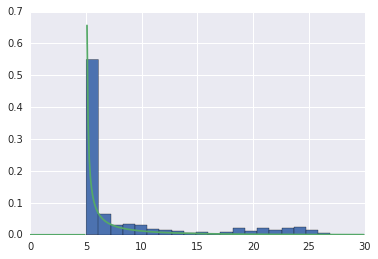

In [7]:
plt.hist(np.array(G.trace['gamma']), normed=True, bins=20)
plt.plot(xspace, known)

So, our empirical distribution is pretty close to the theoretical distribution.

In [8]:
gamma.accept_rate

0.516

Our accept rate is right on the money.

If we wanted to, we could change the default scale parameter of the proposal:

In [9]:
gamma._move_size

1.0

Let's see what happens when we reduce the scale of the proposal:

In [10]:
gamma._move_size = .8
gamma.n_accepted = 0

In [11]:
G = Gibbs()
G.add_steps(gamma)
G.sample(1000)

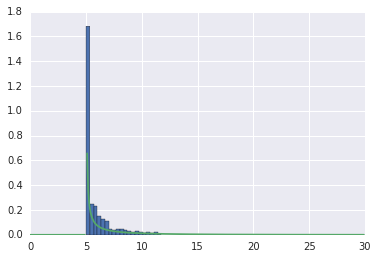

In [12]:
plt.hist(np.array(G.trace['gamma']), normed=True, bins=20)
plt.plot(xspace, known)

In [13]:
gamma.accept_rate

0.369

So, with a smaller step size, our acceptance rate gets worse. You can see in the distplot that the sampler is sitting right at the cusp of the domain and getting invalid values off the domain of the gamma, all the locations below 4. 

Typically, a way this can be fixed is to use adaptive tuning. Right now, the adapt rate is set to one by default:

In [14]:
gamma._adapt_rate

1

Meaning the scale parameter on the proposal never changes in response to the acceptance rate. 

Let's introduce some mild shaping, so that if we go out of the acceptance bounds, we shift the scale of the proposal. In addition, let's start with a large step so that the adaptation has enough information to reduce:

In [15]:
gamma._adapt_rate = 1.001
gamma._move_size = 5
gamma.n_accepted = 0

Let's do a burnin adaptation of 100 steps, then proceed at whatever scale is found in the first 100 steps

In [16]:
G = Gibbs()
G.add_steps(gamma)
G.sample(100)
gamma.adapt_rate = 1
G.sample(1000)

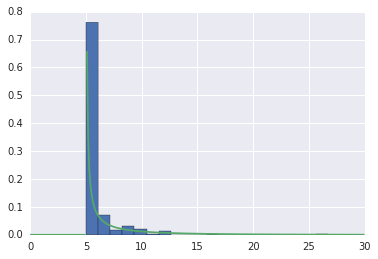

In [17]:
plt.hist(np.array(G.trace['gamma'][100:]), normed=True, bins=20)
plt.plot(xspace, known)

In [18]:
gamma._move_size

13.956212568054086

In [19]:
gamma.accept_rate

0.09727272727272727

This gives us a very low acceptance rate, and we marginally oversample at the peak of the gamma, and do not get any samples far out in the tail of the distribution.

This indicates that it is very easy for the metropolis to oversample on the edge of a domain, since its rejection rates increase dramatically, because:

In [20]:
stats.gamma.pdf(3, gamma.A, loc=gamma.loc, scale=gamma.scale)

0.0

The gamma function will never return probability in this space. 

But, we can improve our sampling using a correctly-truncated proposal. 

In [21]:
from functools import partial

In [22]:
def trunc_propose(self, current_value):
    current_low = (self.clip_low - current_value) / self._move_size
    current_up = (self.clip_up - current_value) / self._move_size
    new = stats.truncnorm.rvs(current_low, current_up, 
                          loc=current_value, scale=self._move_size)
    #now, since we know the proposal is truncated, it's not symmetric
    #so we actually need to calculate the hastings factor. To do this,
    #we also have to calculate new relative clips:
    new_low = (self.clip_low - new) / self._move_size
    new_up = (self.clip_up - new) / self._move_size
    
    forward = stats.truncnorm.logpdf(new, current_low, current_up, 
                                     loc=current_value, scale=self._move_size)
    backward = stats.truncnorm.logpdf(current_value, new_low, new_up, 
                                      loc=new, scale=self._move_size)
    
    return new, forward, backward

In [23]:
G = Gibbs()
tprop = MetTest(name='trunc_proposal')
tprop.initial = 6
tprop._propose = partial(trunc_propose, tprop)
tprop.clip_low = 4
tprop.clip_up = 1000
tprop._adapt_rate = 1.01
G.add_steps(tprop)
G.sample(100)
tprop._adapt_rate = 1
G.sample(1000)

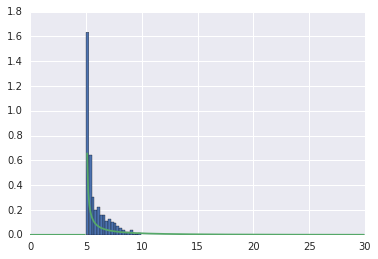

In [24]:
plt.hist(np.array(G.trace['trunc_proposal'][100:]), normed=True, bins=20)
plt.plot(xspace, known)

And, while we still oversample in the densest regions, the distribution is much closer our target than the original. 

But, what if we wanted to restrict the proposal distribution to be within a certain bounds on both sides, say if we're sampling from some kind of restricted or truncated distribution?

In [25]:
clip_low = -1
clip_up = 4

In [26]:
def trunc_propose(self, current_value):
    current_low = (self.clip_low - current_value) / self._move_size
    current_up = (self.clip_up - current_value) / self._move_size
    new = stats.truncnorm.rvs(current_low, current_up, 
                          loc=current_value, scale=self._move_size)
    #now, since we know the proposal is truncated, it's not symmetric
    #so we actually need to calculate the hastings factor. To do this,
    #we also have to calculate new relative clips:
    new_low = (self.clip_low - new) / self._move_size
    new_up = (self.clip_up - new) / self._move_size
    
    forward = stats.truncnorm.logpdf(new, current_low, current_up, 
                                     loc=current_value, scale=self._move_size)
    backward = stats.truncnorm.logpdf(current_value, new_low, new_up, 
                                      loc=new, scale=self._move_size)
    
    return new, forward, backward

In [27]:
from functools import partial
def tnorm_logp(self, value):
    return stats.truncnorm.logpdf(value, self.clip_low, self.clip_up, loc=2, scale=1)

In [28]:
G = Gibbs()
tnorm = MetTest(name='trunc_norm')
tnorm._logp = partial(tnorm_logp, tnorm)
tnorm.initial = 3
tnorm._propose = partial(trunc_propose, tnorm)
tnorm.clip_low = clip_low
tnorm.clip_up = clip_up
tnorm._adapt_rate=1.001
G.add_steps(tnorm)
G.sample(100)
tnorm._adapt_rate=1.0
G.sample(10000)

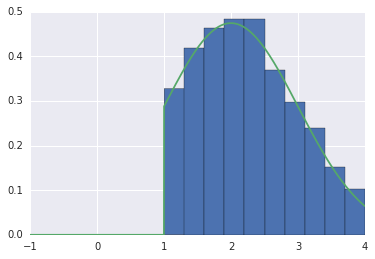

In [29]:
plt.hist(G.trace['trunc_norm'][100:], normed=True)
xspace = np.arange(clip_low, clip_up, .001)
y = [stats.truncnorm.pdf(x, clip_low, clip_up, loc=2, scale=1) for x in xspace]
plt.plot(xspace, y)
#sns.distplot(known_kde, kde=False, fit=stats.gamma, fit_kws={'alpha':.5, 'color':'r'})

And so, now we have an adaptive metropolis sampler that can deal with arbitrarily-restricted parameters. 